In [1]:
import pandas as pd
import ast
import spacy
import re
import os
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotx

# Load Rebel Triplets & Obtain Suitable Triplet Format for Neo4j

In [62]:
rebel_triplets = pd.read_csv("REBEL_triples_per_sentence.csv")

def convert_to_list(column):
    return column.apply(ast.literal_eval)

rebel_triplets['triplets_clean_sent'] = convert_to_list(rebel_triplets['triplets_clean_sent'])

rebel_triplets.head()

,Title,Articles,coreference_list_ready,coreference_paragraph_clean,coreference_sentence_clean,coreference_sentence,triplets_clean_sent
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[[{'head': 'european atomic energy community',..."
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,‘applicant’ means a natural person or an entit...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,‘applicant’ means a natural person or an entit...,"[[{'head': 'natural person', 'type': 'subclass..."
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,"‘application document’ means a tender, a reque...",application document means a tender a request ...,application document means a tender a request ...,"‘application document’ means a tender, a reque...","[[{'head': 'grant application', 'type': 'subcl..."
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,‘award procedure’ means a procurement procedur...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,‘award procedure’ means a procurement procedur...,"[[{'head': 'procurement', 'type': 'part of', '..."
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,"‘basic act’ means a legal act, other than a re...",basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"‘basic act’ means a legal act, other than a re...","[[{'head': 'euratom treaty', 'type': 'followed..."


In [63]:
rebel_triplets.isna().sum()

Title                          0
Articles                       0
coreference_list_ready         0
coreference_paragraph_clean    0
coreference_sentence_clean     0
coreference_sentence           0
triplets_clean_sent            0
dtype: int64

In [64]:
rebel_triplets_exploded = rebel_triplets.explode("triplets_clean_sent")

In [65]:
def triplet_tuple(triplet_dictionary):

    return (triplet_dictionary[0]["head"], triplet_dictionary[0]["type"], triplet_dictionary[0]["tail"])

In [66]:
empty_triplets = rebel_triplets_exploded[rebel_triplets_exploded['triplets_clean_sent'].apply(lambda x: len(x) == 0)]
print(empty_triplets)

                                                  Title  \
12    TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...   
12    TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...   
46    TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...   
51    TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...   
88          TITLE II \nBUDGET AND BUDGETARY PRINCIPLES    
106         TITLE II \nBUDGET AND BUDGETARY PRINCIPLES    
106         TITLE II \nBUDGET AND BUDGETARY PRINCIPLES    
184         TITLE II \nBUDGET AND BUDGETARY PRINCIPLES    
689                   TITLE IV \nBUDGET IMPLEMENTATION    
719                   TITLE IV \nBUDGET IMPLEMENTATION    
719                   TITLE IV \nBUDGET IMPLEMENTATION    
719                   TITLE IV \nBUDGET IMPLEMENTATION    
969                   TITLE IV \nBUDGET IMPLEMENTATION    
987                             TITLE V \nCOMMON RULES    
1025                            TITLE V \nCOMMON RULES    
1684  TITLE XI \nCONTRIBUTIONS TO EUROPEAN POLITICAL... 

In [67]:
def triplet_tuple(triplet_dictionary):
    if not triplet_dictionary:  # Check if the list is empty
        return None  # Return a tuple of Nones or handle as desired
    return (triplet_dictionary[0]["head"], triplet_dictionary[0]["type"], triplet_dictionary[0]["tail"])

In [68]:
rebel_triplets_exploded['Triplet'] = rebel_triplets_exploded['triplets_clean_sent'].apply(triplet_tuple)

In [69]:
rebel_triplets_exploded["Head"] = rebel_triplets_exploded["Triplet"].apply(lambda x: x[0].strip() if x is not None else None)
rebel_triplets_exploded["Relation"] = rebel_triplets_exploded["Triplet"].apply(lambda x: x[1].strip() if x is not None else None)
rebel_triplets_exploded["Tail"] = rebel_triplets_exploded["Triplet"].apply(lambda x: x[2].strip() if x is not None else None)

In [70]:
rebel_triplets_exploded.head()

,Title,Articles,coreference_list_ready,coreference_paragraph_clean,coreference_sentence_clean,coreference_sentence,triplets_clean_sent,Triplet,Head,Relation,Tail
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[{'head': 'european atomic energy community', ...","(european atomic energy community, part of, eu...",european atomic energy community,part of,european union
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[{'head': 'european atomic energy community', ...","(european atomic energy community, parent orga...",european atomic energy community,parent organization,european union
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[{'head': 'european atomic energy community', ...","(european atomic energy community, country, eu...",european atomic energy community,country,european union
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,‘applicant’ means a natural person or an entit...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,‘applicant’ means a natural person or an entit...,"[{'head': 'natural person', 'type': 'subclass ...","(natural person, subclass of, entity)",natural person,subclass of,entity
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,‘applicant’ means a natural person or an entit...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,‘applicant’ means a natural person or an entit...,"[{'head': 'natural person', 'type': 'subclass ...","(natural person, subclass of, entity)",natural person,subclass of,entity


# Preprocess the Dataframe
* Check for NA values 
* Lowercase, Remove Punctuation, Stopwords and Lemmatize 
* Remove Noise from Text such as \n sumbols and unncessary spaces

In [71]:
rebel_triplets_exploded.isna().sum()

Title                           0
Articles                        0
coreference_list_ready          0
coreference_paragraph_clean     0
coreference_sentence_clean      0
coreference_sentence            0
triplets_clean_sent             0
Triplet                        31
Head                           31
Relation                       31
Tail                           31
dtype: int64

In [72]:
rebel_triplets_exploded = rebel_triplets_exploded.dropna()

In [73]:
# Remove stopwords, punctuation from heads 
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")


stop_words = spacy.lang.en.stop_words.STOP_WORDS 
stopwords = list(stop_words)
punctuation = '!@#$%^&*_-+={}[];"\'|<>,?/~`’‘()'



def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def tokens(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token)
    return tokens

def remove_punct(text):
    tokens_list = tokens(text)
    new_list = []
    for token in tokens_list:
        new_token = ""
        for letter in token.text:
            if letter not in punctuation:
                new_token = new_token + letter
        new_list.append(new_token)
    return new_list

def remove_punct_text(text):
    tokens_list = tokens(text)
    new_list = []
    for token in tokens_list:
        new_token = ""
        for letter in token.text:
            if letter not in punctuation:
                new_token = new_token + letter
        new_list.append(new_token)
    return " ".join(new_list)

def remove_stopwords(text):
    text_tokens = remove_punct(text.lower())
    new_text = " "
    for token in text_tokens:
        if token not in stopwords:
               new_text = new_text + ' ' + str(token)
    return lemmatize(new_text).strip()

def remove_stopwords_no_lemma(text):
    text_tokens = remove_punct(text)
    new_text = " "
    for token in text_tokens:
        if token not in stopwords:
               new_text = new_text + ' ' + str(token)
    return new_text.strip()

In [74]:
# Identify entities that are numbers and keep rows that do not have head or tail that are numbers

rebel_triplets_exploded['Head_is_Number'] = rebel_triplets_exploded["Head"].apply(lambda x: x.isdigit())
rebel_triplets_exploded['Tail_is_Number'] = rebel_triplets_exploded["Tail"].apply(lambda x: x.isdigit())

rebel_triplets_exploded = rebel_triplets_exploded[(rebel_triplets_exploded["Tail_is_Number"]==False) & (rebel_triplets_exploded["Head_is_Number"]==False)]

In [75]:
# Lowercase and remove stopwords

rebel_triplets_exploded['Head'] = rebel_triplets_exploded["Head"].apply(remove_stopwords)
rebel_triplets_exploded['Tail'] = rebel_triplets_exploded["Tail"].apply(remove_stopwords)

In [76]:
pattern = '\n'
rebel_triplets_exploded['Title'] = rebel_triplets_exploded['Title'].apply(lambda x: re.sub(pattern, '', x).strip())

rebel_triplets_exploded["Articles"] = rebel_triplets_exploded["Articles"].apply(lambda x: x.strip())

In [77]:
rebel_triplets_exploded['Title'].unique()

array(['TITLE I SUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES',
       'TITLE II BUDGET AND BUDGETARY PRINCIPLES',
       'TITLE III ESTABLISHMENT AND STRUCTURE OF THE BUDGET',
       'TITLE IV BUDGET IMPLEMENTATION', 'TITLE V COMMON RULES',
       'TITLE VI INDIRECT MANAGEMENT',
       'TITLE VII PROCUREMENT AND CONCESSIONS', 'TITLE VIII GRANTS',
       'TITLE IX PRIZES',
       'TITLE X FINANCIAL INSTRUMENTS, BUDGETARY GUARANTEES AND FINANCIAL ASSISTANCE',
       'TITLE XI CONTRIBUTIONS TO EUROPEAN POLITICAL PARTIES',
       'TITLE XII OTHER BUDGET IMPLEMENTATION INSTRUMENTS',
       'TITLE XIII ANNUAL ACCOUNTS AND OTHER FINANCIAL REPORTING',
       'TITLE XIV EXTERNAL AUDIT AND DISCHARGE',
       'TITLE XV ADMINISTRATIVE APPROPRIATIONS',
       'TITLE XVI INFORMATION REQUESTS AND DELEGATED ACTS'], dtype=object)

In [78]:
rebel_triplets_exploded.reset_index(inplace=True, drop=True)

In [79]:
rebel_triplets_exploded.shape

(6516, 13)

In [80]:
rebel_triplets_exploded.isna().sum()

Title                          0
Articles                       0
coreference_list_ready         0
coreference_paragraph_clean    0
coreference_sentence_clean     0
coreference_sentence           0
triplets_clean_sent            0
Triplet                        0
Head                           0
Relation                       0
Tail                           0
Head_is_Number                 0
Tail_is_Number                 0
dtype: int64

# Get Original The original Content of each Article and Merge with the Rebel Dataframe

In [81]:
original_text = pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\final_dataframe.csv')

original_text['Content'] = convert_to_list(original_text['Content'])

original_text["Articles"] = original_text["Articles"].apply(lambda x: x.strip())

original_text = original_text[["Articles","Content"]]

In [82]:
def get_content(con_list):
    con_text = "".join(con_list).strip()
    con_text = re.sub('\n', '', "".join(con_text))
    con_text = re.sub('  ', ' ', con_text)

    return con_text

def denoise_paragraph(paragraph):
    para_text = re.sub('\n', '', paragraph.strip())
    
    return para_text
    
original_text["Content_Text"] = original_text["Content"].apply(get_content)

original_text = original_text.explode("Content")

original_text["Paragraph_Text"] = original_text["Content"].apply(denoise_paragraph)

original_text = original_text[["Articles","Content_Text","Paragraph_Text"]]

In [83]:
original_text

,Articles,Content_Text,Paragraph_Text
0,Article 1 Subject matter,This Regulation lays down the rules for the es...,This Regulation lays down the rules for the es...
1,Article 2 Definitions,‘applicant’ means a natural person or an entit...,‘applicant’ means a natural person or an entit...
1,Article 2 Definitions,‘applicant’ means a natural person or an entit...,"‘application document’ means a tender, a reque..."
1,Article 2 Definitions,‘applicant’ means a natural person or an entit...,‘award procedure’ means a procurement procedur...
1,Article 2 Definitions,‘applicant’ means a natural person or an entit...,"‘basic act’ means a legal act, other than a re..."
...,...,...,...
280,Article 281 Repeal,"Regulation (EU, Euratom) No 966/2012 is repeal...","Without prejudice to Article 279(3), the Commi..."
280,Article 281 Repeal,"Regulation (EU, Euratom) No 966/2012 is repeal...",References to the repealed Regulation shall be...
281,Article 282 Entry into force and application,This Regulation shall enter into force on the ...,This Regulation shall enter into force on the ...
281,Article 282 Entry into force and application,This Regulation shall enter into force on the ...,It shall apply from 2 August 2018.


In [84]:
# Dictionary {Article:Content}

article_content = original_text[["Articles","Content_Text"]]

article_content.drop_duplicates(["Articles","Content_Text"], inplace=True, ignore_index=True)

C:\Users\Student\AppData\Local\Temp\ipykernel_8056\4016803028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_content.drop_duplicates(["Articles","Content_Text"], inplace=True, ignore_index=True)


In [85]:
article_content

,Articles,Content_Text
0,Article 1 Subject matter,This Regulation lays down the rules for the es...
1,Article 2 Definitions,‘applicant’ means a natural person or an entit...
2,Article 3 Compliance of secondary legislation...,Provisions concerning the implementation of th...
3,"Article 4 Periods, dates and time limits","Unless otherwise provided in this Regulation, ..."
4,Article 5 Protection of personal data,This Regulation is without prejudice to Regula...
...,...,...
277,Article 278 Amendment to Decision No 541/2014/EU,In Article 4 of Decision No 541/2014/EU of the...
278,Article 279 Transitional provisions,Legal commitments for grants implementing the ...
279,Article 280 Review,This Regulation shall be reviewed whenever it ...
280,Article 281 Repeal,"Regulation (EU, Euratom) No 966/2012 is repeal..."


In [86]:
rebel_triplets_exploded = pd.merge(rebel_triplets_exploded, article_content, on='Articles', how='left')

In [87]:
rebel_triplets_exploded.shape

(6516, 14)

In [88]:
rebel_triplets_exploded.head()

,Title,Articles,coreference_list_ready,coreference_paragraph_clean,coreference_sentence_clean,coreference_sentence,triplets_clean_sent,Triplet,Head,Relation,Tail,Head_is_Number,Tail_is_Number,Content_Text
0,"TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 1 Subject matter,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[{'head': 'european atomic energy community', ...","(european atomic energy community, part of, eu...",european atomic energy community,part of,european union,False,False,This Regulation lays down the rules for the es...
1,"TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 1 Subject matter,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[{'head': 'european atomic energy community', ...","(european atomic energy community, parent orga...",european atomic energy community,parent organization,european union,False,False,This Regulation lays down the rules for the es...
2,"TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 1 Subject matter,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[{'head': 'european atomic energy community', ...","(european atomic energy community, country, eu...",european atomic energy community,country,european union,False,False,This Regulation lays down the rules for the es...
3,"TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,‘applicant’ means a natural person or an entit...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,‘applicant’ means a natural person or an entit...,"[{'head': 'natural person', 'type': 'subclass ...","(natural person, subclass of, entity)",natural person,subclass of,entity,False,False,‘applicant’ means a natural person or an entit...
4,"TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,‘applicant’ means a natural person or an entit...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,‘applicant’ means a natural person or an entit...,"[{'head': 'natural person', 'type': 'subclass ...","(natural person, subclass of, entity)",natural person,subclass of,entity,False,False,‘applicant’ means a natural person or an entit...


In [89]:
# Change Names

rebel_triplets_exploded.rename(columns={'coreference_list_ready': 'Paragraph_Coreferenced', 
                                        'coreference_sentence': 'Sentence_Coreferenced',
                                        "Content_Text": "Article_Content",
                                        "Articles":"Article"}, inplace=True)



# Save Rebel Triplets for Each Title

In [90]:
output_folder = r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\REBEL_triplets_per_title'
numbers_list = ["I","II","III","IV","V","VI","VII","VIII","IX","X","XI",
                "XII","XIII","XIV","XV","XVI"]
title_list = rebel_triplets_exploded['Title'].unique().tolist()

for title, number in zip(title_list, numbers_list):

    rebel_subset = rebel_triplets_exploded[rebel_triplets_exploded["Title"]==title]

    rebel_subset = rebel_subset[rebel_subset['Head'] != rebel_subset['Tail']]

    rebel_subset.drop_duplicates(["Head","Relation","Tail"], inplace=True, ignore_index=True)

    rebel_subset = rebel_subset[["Head","Relation","Tail","Title","Article","Paragraph_Coreferenced",
                                 "Sentence_Coreferenced","Article_Content"]]

    filename = "rebel_triplets_" + str(number) + ".csv"

    output_file_path = os.path.join(output_folder, filename)
    rebel_subset.to_csv(output_file_path, index=False)

# Save Rebel Triplets for All Titles Together

In [91]:
rebel_triplets_all = rebel_triplets_exploded[rebel_triplets_exploded['Head'] != rebel_triplets_exploded['Tail']]

rebel_triplets_all.drop_duplicates(["Head","Relation","Tail"], inplace=True, ignore_index=True)

rebel_triplets_all = rebel_triplets_all[["Head","Relation","Tail","Title","Article","Paragraph_Coreferenced",
                                 "Sentence_Coreferenced","Article_Content"]]

C:\Users\Student\AppData\Local\Temp\ipykernel_8056\3964410756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebel_triplets_all.drop_duplicates(["Head","Relation","Tail"], inplace=True, ignore_index=True)


In [92]:
rebel_triplets_all.to_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\REBEL_triplets_per_title\REBEL_triplets_ALL_titles.csv', index=False) 

In [93]:
# !pip install matplotx[all]

# Define Visual Exploration Class

In [67]:
class triplets_vis:
    def __init__(self, dataframe, title):
        self.title = title
        self.dataframe = dataframe

        self.unique_relation_per_title = self.dataframe.groupby("Title")[["Relation"]].nunique()
        self.unique_heads_per_title = self.dataframe.groupby("Title")[["Head"]].nunique()
        self.unique_tails_per_title = self.dataframe.groupby("Title")[["Tail"]].nunique()

        self.relations_freq = self.dataframe[self.dataframe["Title"]==self.title].groupby(["Relation"])["Relation"].count().reset_index(name='count').sort_values(by=('count'), ascending=False)
        self.relations_freq['Relative Freq'] = self.relations_freq['count'] / self.relations_freq['count'].sum()
        self.relations_freq = self.relations_freq.rename(columns={"relation": "Relation", "count": "Frequency"})
        self.relations_freq = self.relations_freq.reset_index(drop=True)

        transformer = StandardScaler()
        transformer_scaler = MaxAbsScaler()
        self.relations_freq['Standardized_Frequency'] = transformer.fit_transform(self.relations_freq[['Frequency']]).flatten()
        self.relations_freq['Scaled_Max_Frequency'] = transformer_scaler.fit_transform(self.relations_freq[['Frequency']]).flatten()

        self.relations_freq['Cumulative Frequency'] = self.relations_freq['Frequency'].cumsum()
        self.relations_freq['Relative Cumulative Frequency'] = self.relations_freq['Relative Freq'].cumsum()

    def na_bar_plot(self):
        
        na_values = self.dataframe[self.dataframe["Title"]==self.title][["Head","Relation","Tail"]].isna().sum().to_frame().reset_index()
        na_values = na_values.rename(columns={"index": "Triplet", 0: "Frequency"})
        plt.style.use(matplotx.styles.dracula)
        fig, ax = plt.subplots()

        ax.bar(na_values['Triplet'],na_values['Frequency'])

        ax.set_ylabel('NA Values')
        ax.set_xlabel('Triplet Part')
        ax.set_title('Frequency of NA Values')

        plt.show()

    def na_table(self):

        na_values = self.dataframe[self.dataframe["Title"]==self.title][["Head","Relation","Tail"]].isna().sum().to_frame().reset_index()
        na_values = na_values.rename(columns={"index": "Triplet", 0: "Frequency"})

        return na_values
    
    def freq_bar_plot(self, border):

        plt.style.use(matplotx.styles.dracula)
        fig, ax = plt.subplots()


        ax.barh(self.relations_freq[self.relations_freq['Frequency'] > border]['Relation'], self.relations_freq[self.relations_freq['Frequency'] > border]['Frequency'])
        ax.invert_yaxis()
        ax.set_ylabel('Relation')
        ax.set_xlabel('Frequency')
        ax.set_title("Relation' Frequencies")

        plt.tight_layout()
        # ax.tick_params(axis='y', labelsize=8)

        plt.show()


        plt.style.use(matplotx.styles.dracula)


    def cumulative_freq_plot(self, border):

        fig, ax = plt.subplots()


        ax.plot(self.relations_freq[self.relations_freq['Frequency'] > border]['Relation'], self.relations_freq[self.relations_freq['Frequency'] > border]['Relative Cumulative Frequency'])

        ax.fill_between(
            self.relations_freq[self.relations_freq['Frequency'] > border]['Relation'], 
            self.relations_freq[self.relations_freq['Frequency'] > border]['Relative Cumulative Frequency'], 
            color='skyblue', alpha=0.4
        )


        # ax.invert_yaxis()
        ax.set_ylabel('Cumulative Frequency')
        ax.set_xlabel('Relation')
        ax.set_title('Relations Frequencies')

        plt.xticks(rotation=90)
        plt.tight_layout()
        # ax.tick_params(axis='y', labelsize=8)

        plt.show()

    def relations_type_freq_plot(self):

        plt.style.use(matplotx.styles.dracula)
        fig, ax = plt.subplots()

        bins = np.sort(self.relations_freq['Frequency'].unique())

        ax.hist(self.relations_freq['Frequency'], density=True, bins=bins)

        ax.set_xticks(bins)
        ax.set_xticklabels(bins ,ha='center')

        ax.set_ylabel('Percentage of Relations with Given Frequency')
        ax.set_xlabel('Frequency of Given Relation')
        ax.set_title('Frequency of Relations Based on Type')
        
        plt.show()

# Explore Entities and Relations

In [68]:
rebel_III = pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\REBEL_triplets_per_title\rebel_triplets_III.csv')

In [69]:
rebel_III["Title"].unique()

array(['TITLE III ESTABLISHMENT AND STRUCTURE OF THE BUDGET'],
      dtype=object)

In [70]:
visualization = triplets_vis(rebel_III,'TITLE III ESTABLISHMENT AND STRUCTURE OF THE BUDGET')

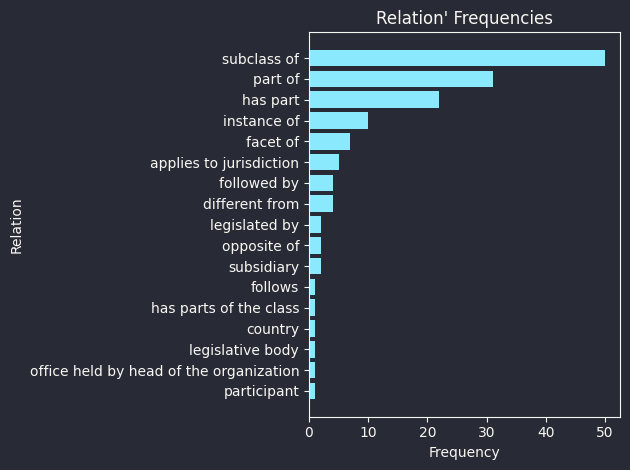

In [71]:
visualization.freq_bar_plot(0)

In [72]:
visualization.relations_freq

,Relation,Frequency,Relative Freq,Standardized_Frequency,Scaled_Max_Frequency,Cumulative Frequency,Relative Cumulative Frequency
0,subclass of,50,0.344828,3.157659,1.00,50,0.344828
1,part of,31,0.213793,1.710959,0.62,81,0.558621
2,has part,22,0.151724,1.025679,0.44,103,0.710345
3,instance of,10,0.068966,0.111974,0.20,113,0.779310
4,facet of,7,0.048276,-0.116453,0.14,120,0.827586
5,applies to jurisdiction,5,0.034483,-0.268737,0.10,125,0.862069
6,followed by,4,0.027586,-0.344879,0.08,129,0.889655
7,different from,4,0.027586,-0.344879,0.08,133,0.917241
8,legislated by,2,0.013793,-0.497163,0.04,135,0.931034
9,opposite of,2,0.013793,-0.497163,0.04,137,0.944828


In [73]:
rebel_III["Head"].unique()

array(['european parliament', 'humanitarian aid crisis response',
       'humanitarian aid', 'crisis response', 'council estimate',
       'parliament', 'draft budget', 'revenue', 'budget', 'union',
       'union institution', 'appropriation', 'budget line', 'point 30',
       'fund', 'commission administration', 'financial instrument',
       'publicprivate partnership', 'equity', 'management fee',
       'operating charge', 'financial operating charge',
       'discharge procedure', 'annual discharge procedure',
       'union basic act', 'trade union', 'union trust fund',
       'court justice', 'competition law', 'woman', 'country', 'post',
       'agriculture', 'expenditure estimate',
       'expenditure estimate agriculture', 'euratom treaty',
       'member state', 'economic forecast',
       'european union solidarity fund', 'solidarity fund', 'draft',
       'previous', 'precede', 'european', 'article 314 tfeu', 'tfeu',
       'chapter 2', 'european council', 'programme',
     

In [74]:
rebel_III["Tail"].unique()

array(['council', 'humanitarian aid', 'humanitarian aid crisis response',
       'councilthe council', 'national parliament', 'budget',
       'expenditure', 'revenue', 'institution', 'union',
       'union institution', 'appropriation', 'policy area',
       'expenditure policy area', 'interinstitutional agreement',
       'budgetary procedure', 'instrument', 'work document', 'debt',
       'administrative expenditure', 'discharge', 'annual discharge',
       'table information', 'table', 'union basic act', 'trust fund',
       'draft budget', 'gender', 'geographic area', 'personnel',
       'letter amendment', 'european parliament', 'president',
       'member state', 'forecast', 'forecast resource',
       'expenditure drive', 'european union', 'amend', 'estimate',
       'amend budget', 'current financial year', 'parliament', 'tfeu',
       'euratom treaty', 'chapter 2', 'council council', 'activity',
       'operational appropriation', 'administrative appropriation',
       'token

# Merge similar entities to a single one

In [75]:
entities_to_merge = {"european council":["council council","councilthe council","council","council union institution"], 
              "union institution":["institution","body"],
              "european parliament":["european","parliament"], 
              "public private partnership":["publicprivate partnership"],
              "basic act":['union basic act'], 
              "european union":["union", "trade union"], 
              'financial operating charge':["operating charge"],
              "annual discharge procedure":['discharge procedure',"discharge","annual discharge"],
              'european union solidarity fund':["solidarity fund"],
              'part time work':["parttime"],
              'crisis response':["humanitarian aid crisis response"],
              'expenditure estimate agriculture':['expenditure estimate','agriculture'],
              'euratop supply agency':["supply agency", "euratom"],
              'leverage effect':['leverage'],
              'european commission':['commission', 'commission type','commission administration'],
              "euratom treaty":["tfeu","article 314 tfeu"],
              "financial instrument":["instrument"],
              "table information":["table"],
              "union trust fund":["trust fund"],
              "member state":["country"],
              "payment appropriations":["payment"],
              "amend budget":["amend", "draft"],
              "provision":["provision title"],
              "expenditure policy area":["policy area"],
              "union act":["act"]
              }

In [76]:
rebel_III.head()

,Head,Relation,Tail,Title,Article,Paragraph_Coreferenced,Sentence_Coreferenced,Article_Content
0,european parliament,has part,council,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,each union institution other than the commissi...,each union institution other than the commissi...,Each Union institution other than the Commissi...
1,humanitarian aid crisis response,facet of,humanitarian aid,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
2,humanitarian aid,facet of,humanitarian aid crisis response,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
3,crisis response,subclass of,humanitarian aid,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
4,european parliament,has part,councilthe council,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the commission shall draw up the commission ow...,the commission shall draw up the commission ow...,Each Union institution other than the Commissi...


In [77]:
# Merge similiar entities 

def replace_entity(value):
    for key, val_list in entities_to_merge.items():
        if value in val_list:
            return key
    return value

rebel_III['Head'] = rebel_III['Head'].apply(replace_entity)
rebel_III['Tail'] = rebel_III['Tail'].apply(replace_entity)


In [78]:
rebel_III.head()

,Head,Relation,Tail,Title,Article,Paragraph_Coreferenced,Sentence_Coreferenced,Article_Content
0,european parliament,has part,european council,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,each union institution other than the commissi...,each union institution other than the commissi...,Each Union institution other than the Commissi...
1,crisis response,facet of,humanitarian aid,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
2,humanitarian aid,facet of,crisis response,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
3,crisis response,subclass of,humanitarian aid,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
4,european parliament,has part,european council,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the commission shall draw up the commission ow...,the commission shall draw up the commission ow...,Each Union institution other than the Commissi...


In [79]:
rebel_III.shape

(145, 8)

In [80]:
# check for head==Tail instances and remove them 

rebel_III = rebel_III[rebel_III['Head'] != rebel_III['Tail']]


# Remove Abstact Entities


In [81]:
entities_to_remove = ["chapter","precede year","euro","eur","previous year","financial year",
                      "procedure", "chapter 2", "forecast", "forecast resource",
                      "transfer", "programme","activity", "precede", "previous", "current financial year",
                      "estimate", "gender","expenditure drive","geographic area"]

In [82]:
rebel_III['Head'] = rebel_III['Head'].apply(lambda x: np.nan if x in entities_to_remove else x)

rebel_III['Tail'] = rebel_III['Tail'].apply(lambda x: np.nan if x in entities_to_remove else x)

C:\Users\Student\AppData\Local\Temp\ipykernel_12116\1660623365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebel_III['Head'] = rebel_III['Head'].apply(lambda x: np.nan if x in entities_to_remove else x)
C:\Users\Student\AppData\Local\Temp\ipykernel_12116\1660623365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebel_III['Tail'] = rebel_III['Tail'].apply(lambda x: np.nan if x in entities_to_remove else x)


In [83]:
rebel_III.isna().sum()

Head                      13
Relation                   0
Tail                      18
Title                      0
Article                    0
Paragraph_Coreferenced     0
Sentence_Coreferenced      0
Article_Content            0
dtype: int64

In [84]:
rebel_III.dropna(inplace=True, ignore_index=True)

C:\Users\Student\AppData\Local\Temp\ipykernel_12116\314120051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebel_III.dropna(inplace=True, ignore_index=True)


In [85]:
rebel_III.shape

(108, 8)

In [86]:
# Merge Relations 

relations_to_merge = {"subclass of":["part of","subsidiary",
                                     "has part", "facet of", "has parts of the class", "participant"],
                      "different from":["opposite of"]}


def replace_relation(value):
    for key, val_list in relations_to_merge.items():
        if value in val_list:
            return key
    return value

rebel_III['Relation'] = rebel_III['Relation'].apply(replace_relation)



C:\Users\Student\AppData\Local\Temp\ipykernel_12116\3866832044.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebel_III['Relation'] = rebel_III['Relation'].apply(replace_relation)


In [87]:
rebel_III["Relation"].unique()

array(['subclass of', 'instance of', 'different from',
       'applies to jurisdiction', 'legislated by',
       'office held by head of the organization', 'country'], dtype=object)

In [88]:
rebel_III.duplicated(["Head","Relation","Tail"]).sum()

24

In [89]:
# check for triplet duplicates 
rebel_III.drop_duplicates(["Head","Relation","Tail"], inplace=True, ignore_index=True)


C:\Users\Student\AppData\Local\Temp\ipykernel_12116\3384274423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebel_III.drop_duplicates(["Head","Relation","Tail"], inplace=True, ignore_index=True)


In [90]:
rebel_III = rebel_III[rebel_III['Head'] != rebel_III['Tail']]

In [91]:
rebel_III.to_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\REBEL_triplets_per_title\rebel_triplets_III_clean.csv', index=False) 

# Assign Classes to Entities
* Use Already defined classes of the use case III
* Assign new Classes if found 

### Categories for Entities of III 

In [45]:
rebel_III = pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\REBEL_triplets_per_title\rebel_triplets_III_clean.csv')

In [46]:
rebel_III.head()

,Head,Relation,Tail,Head_Class,Tail_Class,Title,Article,Paragraph_Coreferenced,Sentence_Coreferenced,Article_Content
0,European Parliament,SUBCLASS OF,European Council,European_Union,European_Union,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,each union institution other than the commissi...,each union institution other than the commissi...,Each Union institution other than the Commissi...
1,Crisis Response,SUBCLASS OF,Humanitarian Aid,EU_Action,Aid,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
2,Humanitarian Aid,SUBCLASS OF,Crisis Response,Aid,EU_Action,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
3,Council Estimate,SUBCLASS OF,European Council,Estimates,European_Union,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the commission shall draw up the commission ow...,"in preparing the council estimates, the commis...",Each Union institution other than the Commissi...
4,European Parliament,SUBCLASS OF,National Parliament,European_Union,European_Union,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 41 Draft budget,the commission shall submit a proposal contain...,"the draft budget shall transmit that proposal,...",The Commission shall submit a proposal contain...


In [47]:

rebel_III['Head'] = rebel_III['Head'].apply(lambda x: x.title())
rebel_III['Tail'] = rebel_III['Tail'].apply(lambda x: x.title())
rebel_III['Relation'] = rebel_III['Relation'].apply(lambda x: x.upper())

In [48]:
rebel_III["Head"].unique()

array(['European Parliament', 'Crisis Response', 'Humanitarian Aid',
       'Council Estimate', 'Draft Budget', 'Revenue', 'Budget',
       'European Union', 'Union Institution', 'Appropriation',
       'Budget Line', 'Point 30', 'Fund', 'European Commission',
       'Public Private Partnership', 'Equity', 'Management Fee',
       'Financial Operating Charge', 'Annual Discharge Procedure',
       'Financial Instrument', 'Basic Act', 'Court Justice',
       'Competition Law', 'Post', 'Expenditure Estimate Agriculture',
       'Euratom Treaty', 'Member State', 'European Union Solidarity Fund',
       'Amend Budget', 'European Council', 'Administrative Appropriation',
       'Operational Appropriation', 'Pro Memoria', 'Establishment Plan',
       'Administrative Expenditure', 'Net Amount', 'Provision',
       'Negative Reserve', 'Payment Appropriations', 'Emergency Aid',
       'International Monetary Fund', 'Reserve', 'Financial Assistance',
       'Leverage Effect', 'Debt Management', '

In [49]:
rebel_III["Tail"].unique()

array(['European Council', 'Humanitarian Aid', 'Crisis Response',
       'National Parliament', 'Budget', 'Expenditure', 'Revenue',
       'Union Institution', 'European Union', 'Appropriation',
       'Expenditure Policy Area', 'Interinstitutional Agreement',
       'Budgetary Procedure', 'Work Document', 'Debt',
       'Administrative Expenditure', 'Table Information', 'Basic Act',
       'Draft Budget', 'Personnel', 'Letter Amendment',
       'European Parliament', 'President', 'Member State', 'Amend Budget',
       'Operational Appropriation', 'Administrative Appropriation',
       'Token Entry', 'Token', 'Multiannual Financial Framework',
       'European Commission', 'Remuneration', 'Provision', 'Budget Line',
       'Euratom Treaty', 'Payment Appropriations', 'World Bank',
       'Emergency Aid', 'Budgetary Guarantee', 'Capital Operation',
       'Financial Instrument', 'Work', 'Salary'], dtype=object)

In [7]:
rebel_III.to_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\REBEL_triplets_per_title\rebel_triplets_III_clean.csv', index=False)

# Count Entities per Category - Visualize

In [22]:
rebel_III = pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\REBEL_triplets_per_title\rebel_triplets_III_clean.csv')

In [23]:
rebel_III.head()

,Head,Relation,Tail,Head_Class,Tail_Class,Title,Article,Paragraph_Coreferenced,Sentence_Coreferenced,Article_Content
0,European Parliament,SUBCLASS OF,European Council,European_Union,European_Union,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,each union institution other than the commissi...,each union institution other than the commissi...,Each Union institution other than the Commissi...
1,Crisis Response,SUBCLASS OF,Humanitarian Aid,EU_Action,Aid,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
2,Humanitarian Aid,SUBCLASS OF,Crisis Response,Aid,EU_Action,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the high representative shall hold consultatio...,the high representative shall hold consultatio...,Each Union institution other than the Commissi...
3,Council Estimate,SUBCLASS OF,European Council,Estimates,European_Union,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 39 Estimates of revenue and expenditure,the commission shall draw up the commission ow...,"in preparing the council estimates, the commis...",Each Union institution other than the Commissi...
4,European Parliament,SUBCLASS OF,National Parliament,European_Union,European_Union,TITLE III ESTABLISHMENT AND STRUCTURE OF THE B...,Article 41 Draft budget,the commission shall submit a proposal contain...,"the draft budget shall transmit that proposal,...",The Commission shall submit a proposal contain...


In [24]:
for name in rebel_III.columns:
     rebel_III[name] = rebel_III[name].apply(lambda x: x.strip())

In [25]:
tail_class = rebel_III["Tail_Class"].to_list()
head_class = rebel_III["Head_Class"].to_list()

In [26]:


class_dictionary_unique_entities = {}
for class_name_t in tail_class:
    if class_name_t not in class_dictionary_unique_entities.keys():
        class_dictionary_unique_entities[class_name_t] = []

for class_name_h in head_class:
    if class_name_h not in class_dictionary_unique_entities.keys():
        class_dictionary_unique_entities[class_name_h] = []



In [27]:
class_dictionary_unique_entities

{'European_Union': [],
 'Aid': [],
 'EU_Action': [],
 'Budget': [],
 'Estimates': [],
 'Appropriations': [],
 'Legal_Construct': [],
 'Draft_Budget': [],
 'Working_Documents': [],
 'Financial_Tool': [],
 'Human_Resources': [],
 'Budget_Amendment': [],
 'Person': [],
 'Budget_Tool': [],
 'Provisions': [],
 'International_Organization': [],
 'Fund': []}

In [28]:
for index, row in rebel_III.iterrows():
    if row[0] not in class_dictionary_unique_entities[row[3]]:
        class_dictionary_unique_entities[row[3]].append(row[0])
    if row[2] not in class_dictionary_unique_entities[row[4]]:
        class_dictionary_unique_entities[row[4]].append(row[2])

C:\Users\Student\AppData\Local\Temp\ipykernel_14328\4118598754.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in class_dictionary_unique_entities[row[3]]:
C:\Users\Student\AppData\Local\Temp\ipykernel_14328\4118598754.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_dictionary_unique_entities[row[3]].append(row[0])
C:\Users\Student\AppData\Local\Temp\ipykernel_14328\4118598754.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

In [29]:
class_dictionary_unique_entities

{'European_Union': ['European Parliament',
  'European Council',
  'National Parliament',
  'European Union',
  'Union Institution',
  'European Commission',
  'Member State'],
 'Aid': ['Humanitarian Aid', 'Negative Reserve', 'Emergency Aid', 'Reserve'],
 'EU_Action': ['Crisis Response', 'Union Act'],
 'Budget': ['Budget'],
 'Estimates': ['Council Estimate',
  'Revenue',
  'Expenditure',
  'Management Fee',
  'Administrative Expenditure',
  'Financial Operating Charge',
  'Expenditure Estimate Agriculture',
  'Remuneration',
  'Net Amount'],
 'Appropriations': ['Appropriation',
  'Administrative Appropriation',
  'Operational Appropriation',
  'Payment Appropriations'],
 'Legal_Construct': ['Expenditure Policy Area',
  'Point 30',
  'Interinstitutional Agreement',
  'Public Private Partnership',
  'Basic Act',
  'Court Justice',
  'Competition Law',
  'Euratom Treaty',
  'Multiannual Financial Framework'],
 'Draft_Budget': ['Draft Budget', 'Budget Line', 'Budgetary Procedure'],
 'Worki

In [30]:
class_dictionary_total_entities = {}
for class_name_t in tail_class:
    if class_name_t not in class_dictionary_total_entities.keys():
        class_dictionary_total_entities[class_name_t] = []

for class_name_h in head_class:
    if class_name_h not in class_dictionary_total_entities.keys():
        class_dictionary_total_entities[class_name_h] = []




for index, row in rebel_III.iterrows():
     class_dictionary_total_entities[row[3]].append(row[0])
     class_dictionary_total_entities[row[4]].append(row[2])


C:\Users\Student\AppData\Local\Temp\ipykernel_14328\4269189286.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_dictionary_total_entities[row[3]].append(row[0])
C:\Users\Student\AppData\Local\Temp\ipykernel_14328\4269189286.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_dictionary_total_entities[row[4]].append(row[2])


In [31]:
class_dictionary_total_entities

{'European_Union': ['European Parliament',
  'European Council',
  'European Council',
  'European Parliament',
  'National Parliament',
  'European Union',
  'Union Institution',
  'Union Institution',
  'European Union',
  'European Commission',
  'European Union',
  'European Union',
  'European Union',
  'European Union',
  'European Union',
  'European Parliament',
  'European Parliament',
  'European Parliament',
  'European Union',
  'Member State',
  'Member State',
  'European Union',
  'European Union',
  'European Union',
  'European Parliament',
  'European Parliament',
  'European Union',
  'European Council',
  'Union Institution',
  'European Council',
  'Union Institution',
  'European Commission',
  'European Commission',
  'European Union',
  'Union Institution',
  'European Parliament',
  'Union Institution',
  'European Parliament',
  'Union Institution'],
 'Aid': ['Humanitarian Aid',
  'Humanitarian Aid',
  'Negative Reserve',
  'Emergency Aid',
  'Reserve',
  'Eme

In [32]:
# Count unique entities per class
unique_entities_per_cat = {}
total_entities_per_cat = {}

for category in class_dictionary_unique_entities.keys():
    unique_entities_per_cat[category]=len(class_dictionary_unique_entities[category])
    total_entities_per_cat[category]=len(class_dictionary_total_entities[category])






In [33]:
total_entities_per_cat

{'European_Union': 39,
 'Aid': 6,
 'EU_Action': 3,
 'Budget': 15,
 'Estimates': 21,
 'Appropriations': 15,
 'Legal_Construct': 16,
 'Draft_Budget': 9,
 'Working_Documents': 2,
 'Financial_Tool': 11,
 'Human_Resources': 6,
 'Budget_Amendment': 4,
 'Person': 1,
 'Budget_Tool': 12,
 'Provisions': 2,
 'International_Organization': 2,
 'Fund': 4}

In [34]:
unique_entities_per_cat

{'European_Union': 7,
 'Aid': 4,
 'EU_Action': 2,
 'Budget': 1,
 'Estimates': 9,
 'Appropriations': 4,
 'Legal_Construct': 9,
 'Draft_Budget': 3,
 'Working_Documents': 1,
 'Financial_Tool': 9,
 'Human_Resources': 5,
 'Budget_Amendment': 2,
 'Person': 1,
 'Budget_Tool': 6,
 'Provisions': 1,
 'International_Organization': 2,
 'Fund': 2}

In [41]:
total_freq = pd.DataFrame(list(total_entities_per_cat.items()), columns=['Categories', 'Frequency'])

unique_freq = pd.DataFrame(list(unique_entities_per_cat.items()), columns=['Categories', 'Frequency'])

In [42]:
total_freq

,Categories,Frequency
0,European_Union,39
1,Aid,6
2,EU_Action,3
3,Budget,15
4,Estimates,21
5,Appropriations,15
6,Legal_Construct,16
7,Draft_Budget,9
8,Working_Documents,2
9,Financial_Tool,11


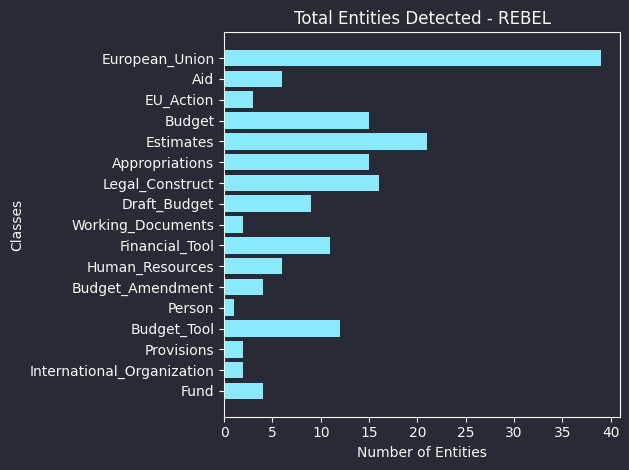

In [43]:
# visualize unique entities per class - barplot

plt.style.use(matplotx.styles.dracula)
        
fig, ax = plt.subplots()


ax.barh(total_freq["Categories"], total_freq["Frequency"])
ax.invert_yaxis()
ax.set_ylabel('Classes')
ax.set_xlabel('Number of Entities')
ax.set_title("Total Entities Detected - REBEL")

plt.tight_layout()
# ax.tick_params(axis='y', labelsize=8)

plt.show()


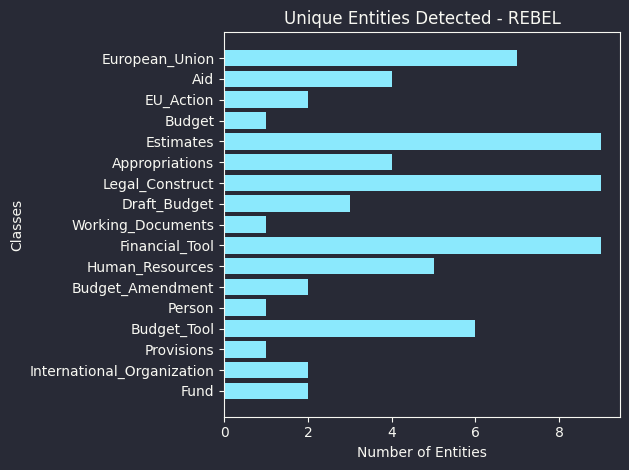

In [44]:
plt.style.use(matplotx.styles.dracula)
        
fig, ax = plt.subplots()


ax.barh(unique_freq["Categories"], unique_freq["Frequency"])
ax.invert_yaxis()
ax.set_ylabel('Classes')
ax.set_xlabel('Number of Entities')
ax.set_title("Unique Entities Detected - REBEL")

plt.tight_layout()
# ax.tick_params(axis='y', labelsize=8)

plt.show()